# Classification using KNN, RF, MLP

Import libraries

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits, load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


Load the datasets 'digits' and 'wine'

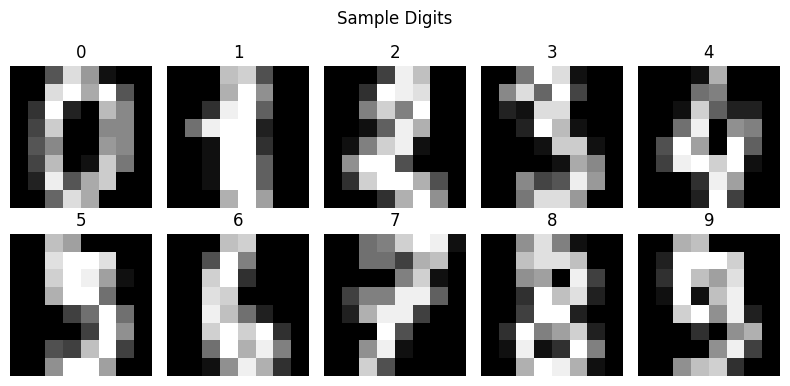

In [4]:
# Load the digits dataset

digits = load_digits()
X_digits = digits.data
y_digits = digits.target
digits_img = digits.images

plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(digits_img[i], cmap="gray")
    plt.title(f"{y_digits[i]}")
    plt.axis("off")
plt.suptitle("Sample Digits")
plt.tight_layout()
plt.show()


In [5]:
# Load the wine dataset

wine = load_wine()
X_wine = wine.data
y_wine = wine.target

Split the datasets into training and testing sets

In [6]:
# digits dataset splitting

X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=42)

In [7]:
# wine dataset splitting

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.2, random_state=42)

Define the KNN pipeline and param grid

In [8]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

knn_param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 13, 15, 20]}

Define the RF pipeline and param grid

In [9]:
rf_pipeline = Pipeline([
    ("rf", RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    "rf__n_estimators": [25, 50, 100, 200, 500],
    "rf__max_depth": [None, 10, 20]}


Define the MLP pipeline and param grid

In [10]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ))
])

mlp_param_grid = {
    "mlp__hidden_layer_sizes": [(64,), (128,), (64, 64)],
    "mlp__activation": ["relu", "tanh"],
    #"mlp__alpha": [0.0001, 0.001],
    "mlp__learning_rate_init": [0.001, 0.01, 1.0, 5.0, 10.0]
}


Train the models

In [11]:
# Function for training

def train_with_timing(pipeline, param_grid, X_train, y_train):
    start = time.time()
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring="f1_weighted",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    train_time = time.time() - start
    return grid, train_time

In [12]:
# Training the model for the digits dataset

knn_grid_digits, knn_train_time_digits  = train_with_timing(knn_pipeline, knn_param_grid, X_train_digits, y_train_digits)
rf_grid_digits, rf_train_time_digits    = train_with_timing(rf_pipeline, rf_param_grid, X_train_digits, y_train_digits)
mlp_grid_digits, mlp_train_time_digits  = train_with_timing(mlp_pipeline, mlp_param_grid, X_train_digits, y_train_digits)

In [13]:
# Training the model for the wine dataset

knn_grid_wine, knn_train_time_wine  = train_with_timing(knn_pipeline, knn_param_grid, X_train_wine, y_train_wine)
rf_grid_wine, rf_train_time_wine    = train_with_timing(rf_pipeline, rf_param_grid, X_train_wine, y_train_wine)
mlp_grid_wine, mlp_train_time_wine  = train_with_timing(mlp_pipeline, mlp_param_grid, X_train_wine, y_train_wine)

Infering the models

In [14]:
# Function to inference the model
def inference_time(model, X_test):
    start = time.time()
    model.predict(X_test)
    return time.time() - start

In [16]:
# inference the digits model

knn_test_time_digits = inference_time(knn_grid_digits.best_estimator_, X_test_digits)
rf_test_time_digits = inference_time(rf_grid_digits.best_estimator_, X_test_digits)
mlp_test_time_digits = inference_time(mlp_grid_digits.best_estimator_, X_test_digits)

In [17]:
# inference the wine model

knn_test_time_wine = inference_time(knn_grid_wine.best_estimator_, X_test_wine)
rf_test_time_wine = inference_time(rf_grid_wine.best_estimator_, X_test_wine)
mlp_test_time_wine = inference_time(mlp_grid_wine.best_estimator_, X_test_wine)

Model evaluation

In [18]:
# Function to evaluate the model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-score": f1_score(y_test, y_pred, average="weighted")
    }

In [19]:
# Evaluate digits model

knn_metrics_digits  = evaluate_model(knn_grid_digits.best_estimator_, X_test_digits, y_test_digits)
rf_metrics_digits   = evaluate_model(rf_grid_digits.best_estimator_, X_test_digits, y_test_digits)
mlp_metrics_digits  = evaluate_model(mlp_grid_digits.best_estimator_, X_test_digits, y_test_digits)

In [20]:
# Evaluate wine model

knn_metrics_wine    = evaluate_model(knn_grid_wine.best_estimator_, X_test_wine, y_test_wine)
rf_metrics_wine     = evaluate_model(rf_grid_wine.best_estimator_, X_test_wine, y_test_wine)
mlp_metrics_wine    = evaluate_model(mlp_grid_wine.best_estimator_, X_test_wine, y_test_wine)

Results and Comparisons

In [21]:
# Result with comparison of the digits model

results_digits_df = pd.DataFrame(
    [knn_metrics_digits, rf_metrics_digits, mlp_metrics_digits],
    index=["KNN", "Random Forest", "MLP"]
)

results_digits_df["Training Time (s)"] = [
    knn_train_time_digits, rf_train_time_digits, mlp_train_time_digits
]

results_digits_df["Inference Time (s)"] = [
    knn_test_time_digits, rf_test_time_digits, mlp_test_time_digits
]

print(results_digits_df)

               Accuracy  Precision    Recall  F1-score  Training Time (s)  \
KNN            0.969444   0.969666  0.969444  0.969287           2.260183   
Random Forest  0.977778   0.978417  0.977778  0.977820          36.526973   
MLP            0.980556   0.980832  0.980556  0.980577          26.680308   

               Inference Time (s)  
KNN                      0.024549  
Random Forest            0.052035  
MLP                      0.001649  


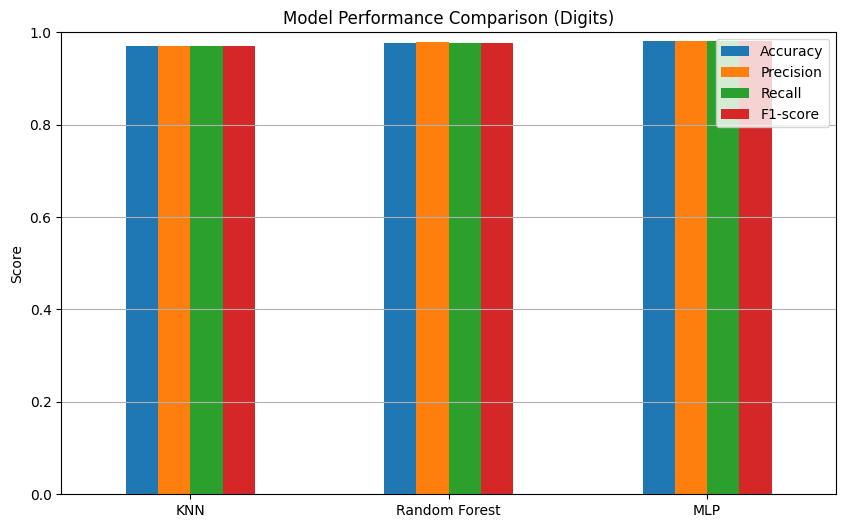

In [22]:
results_digits_df.iloc[:, :4].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison (Digits)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

In [23]:
# Result with comparison of the wine model

results_wine_df = pd.DataFrame(
    [knn_metrics_wine, rf_metrics_wine, mlp_metrics_wine],
    index=["KNN", "Random Forest", "MLP"]
)

results_wine_df["Training Time (s)"] = [
    knn_train_time_wine, rf_train_time_wine, mlp_train_time_wine
]

results_wine_df["Inference Time (s)"] = [
    knn_test_time_wine, rf_test_time_wine, mlp_test_time_wine
]

print(results_wine_df)

               Accuracy  Precision    Recall  F1-score  Training Time (s)  \
KNN            0.972222   0.974074  0.972222  0.972187           0.160956   
Random Forest  1.000000   1.000000  1.000000  1.000000          16.624714   
MLP            1.000000   1.000000  1.000000  1.000000           3.385024   

               Inference Time (s)  
KNN                      0.003417  
Random Forest            0.008552  
MLP                      0.000590  


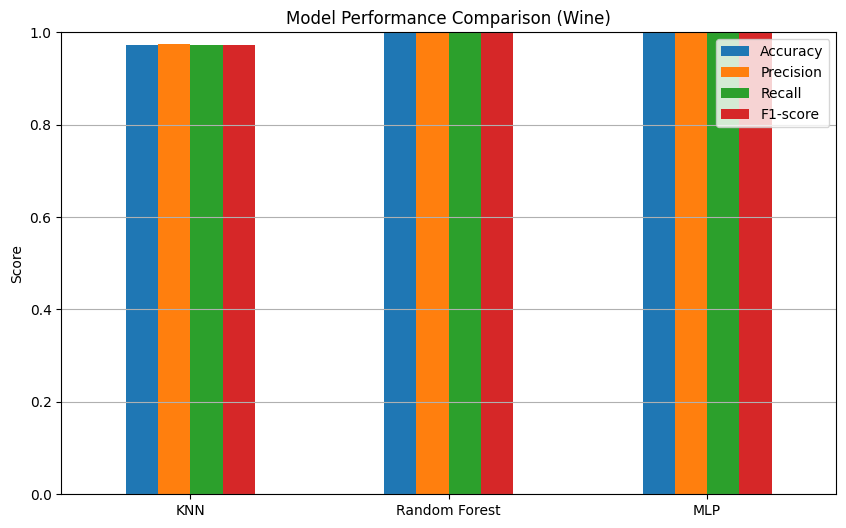

In [24]:
results_wine_df.iloc[:, :4].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison (Wine)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

Confusion Matrices

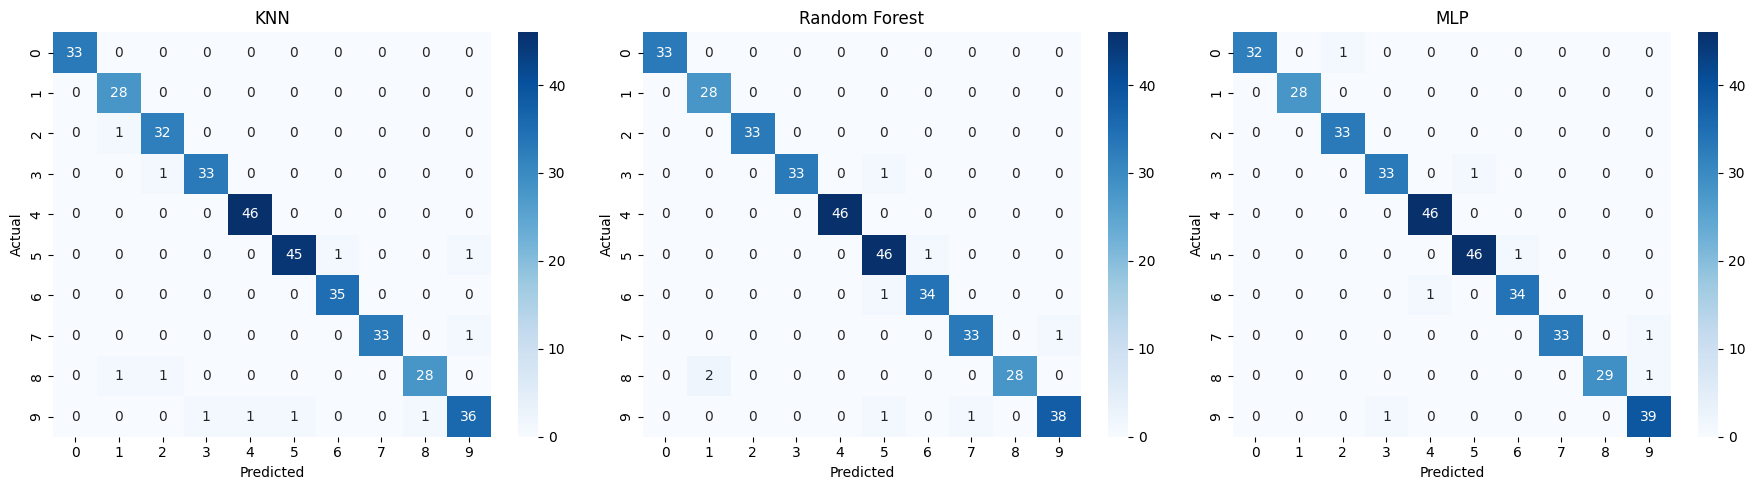

In [25]:
# Confusion matrices for digits model

digits_models = {
    "KNN": knn_grid_digits.best_estimator_,
    "Random Forest": rf_grid_digits.best_estimator_,
    "MLP": mlp_grid_digits.best_estimator_
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, digits_models.items()):
    cm = confusion_matrix(y_test_digits, model.predict(X_test_digits))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

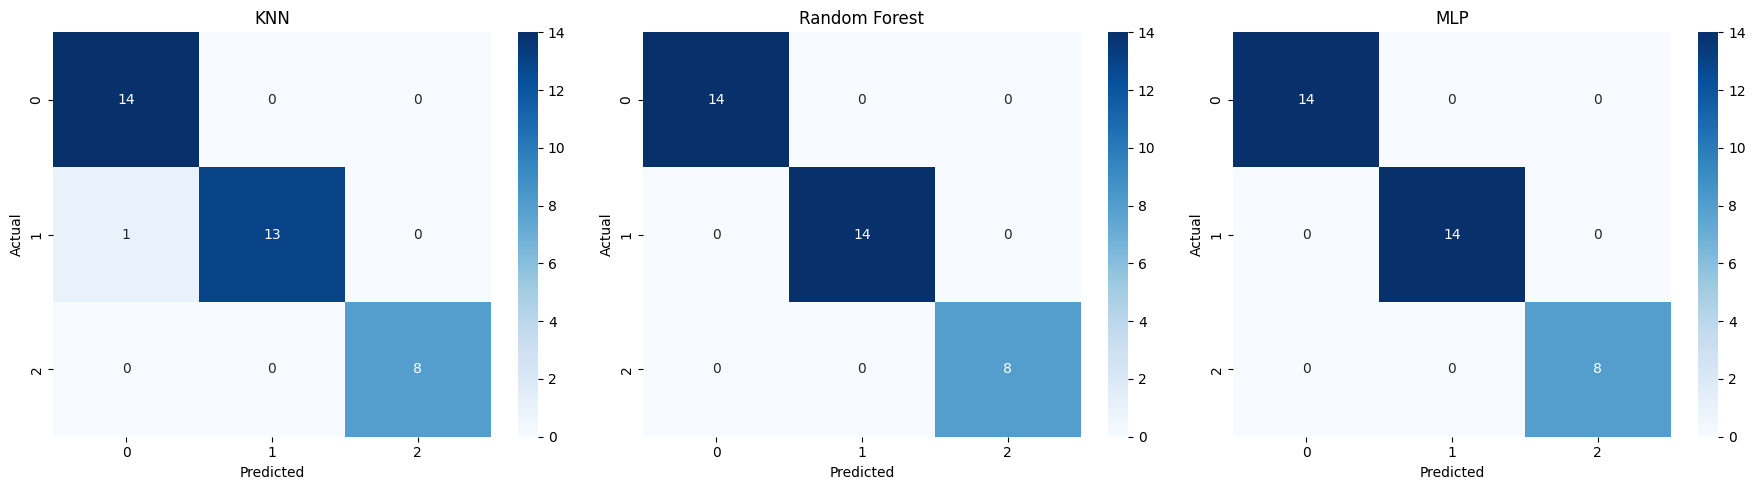

In [26]:
# Confusion matrices for wine model

wine_models = {
    "KNN": knn_grid_wine.best_estimator_,
    "Random Forest": rf_grid_wine.best_estimator_,
    "MLP": mlp_grid_wine.best_estimator_
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, model) in zip(axes, wine_models.items()):
    cm = confusion_matrix(y_test_wine, model.predict(X_test_wine))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()